In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
data_dir = 'gender'

In [3]:
files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]

In [4]:
files_sorted = sorted(files, key=lambda x: int(x.split('_')[1].split('.')[0]))

In [5]:
labels = []
for f in files_sorted:
    idx = int(f.split('_')[1].split('.')[0])
    if idx < 100:
        labels.append('male')
    else:
        labels.append('female')

In [6]:
df = pd.DataFrame({
    'filename': files_sorted,
    'label': labels
})

In [7]:
df['label'].value_counts()

label
male      88
female    88
Name: count, dtype: int64

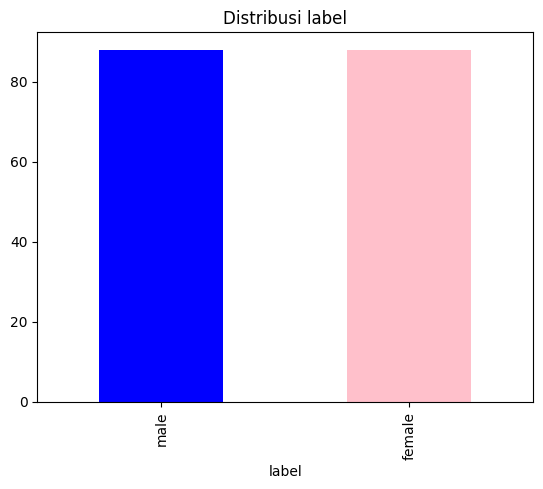

In [8]:
df['label'].value_counts().plot(kind='bar', color=['blue','pink'])
plt.title('Distribusi label')
plt.show()

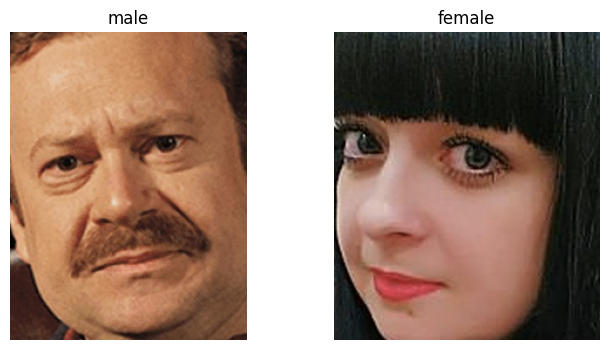

In [9]:
plt.figure(figsize=(8,4))
for i, label in enumerate(['male','female']):
    sample = df[df['label']==label].sample(1).iloc[0]
    img_path = os.path.join(data_dir, sample['filename'])
    img = Image.open(img_path)
    plt.subplot(1,2,i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.show()

In [10]:
missing = []
for fname in df['filename']:
    if not os.path.exists(os.path.join(data_dir, fname)):
        missing.append(fname)

if missing:
    print("File berikut hilang:", missing)
    # Hapus baris yang filenya hilang
    df = df[~df['filename'].isin(missing)]
else:
    print("Semua file ada")

Semua file ada


In [11]:
pip install mtcnn opencv-python albumentations

Note: you may need to restart the kernel to use updated packages.


In [12]:
from mtcnn.mtcnn import MTCNN
import albumentations as A
from tqdm import tqdm
import cv2

In [13]:
input_dir = 'gender'
output_dir = 'preprocessed'
os.makedirs(output_dir, exist_ok=True)

In [14]:
detector = MTCNN()
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5),              # slight rotation
    A.GaussianBlur(blur_limit=3, p=0.3),    # slight blur
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3) # noise
])

C:\Users\I Putu Nanda Aditya\AppData\Local\Temp\ipykernel_18540\3567748855.py:7: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3) # noise


In [15]:
def align_face(image, keypoints):
    left_eye = keypoints['left_eye']
    right_eye = keypoints['right_eye']
    
    # hitung angle
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dy, dx))
    
    # titik tengah kedua mata
    eyes_center = ((left_eye[0] + right_eye[0]) // 2.0,
                   (left_eye[1] + right_eye[1]) // 2.0)
    
    # rotasi gambar
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale=1)
    aligned = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_CUBIC)
    return aligned

In [16]:
import numpy as np

In [17]:
for fname in tqdm(os.listdir(input_dir)):
    if not fname.endswith('.jpg'):
        continue

    fpath = os.path.join(input_dir, fname)
    img = cv2.imread(fpath)
    if img is None:
        print(f"Gagal load {fname}")
        continue
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Deteksi wajah
    faces = detector.detect_faces(img_rgb)
    if len(faces) == 0:
        print(f"Wajah tidak terdeteksi: {fname}")
        continue
    
    face = faces[0]
    x, y, w, h = face['box']
    keypoints = face['keypoints']

    # Align wajah
    aligned = align_face(img_rgb, keypoints)

    # Crop wajah
    cropped = aligned[y:y+h, x:x+w]

    # Resize ke 224x224
    resized = cv2.resize(cropped, (224, 224))

    # Augmentasi
    augmented = augment(image=resized)['image']

    # Normalisasi pixel ke [0,1]
    normalized = augmented / 255.0

    # Simpan hasil preprocessing sebagai .npy (array) atau jpg
    save_name = os.path.splitext(fname)[0] + '.jpg'
    save_path = os.path.join(output_dir, save_name)

    # Convert ke BGR lagi sebelum save, karena cv2.imwrite pakai BGR
    save_img = cv2.cvtColor((normalized*255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, save_img)

print("✅ Selesai preprocessing dan augmentasi! Dataset baru ada di:", output_dir)

  7%|█████▍                                                                           | 12/177 [00:04<01:03,  2.59it/s]

Wajah tidak terdeteksi: face_104_aug11.jpg


  9%|███████▎                                                                         | 16/177 [00:06<00:53,  2.99it/s]

Wajah tidak terdeteksi: face_107_aug9.jpg


 20%|████████████████                                                                 | 35/177 [00:13<00:59,  2.40it/s]

Wajah tidak terdeteksi: face_124_aug3.jpg


 20%|████████████████▍                                                                | 36/177 [00:14<01:03,  2.21it/s]

Wajah tidak terdeteksi: face_124_aug7.jpg


 24%|███████████████████▏                                                             | 42/177 [00:17<01:14,  1.80it/s]

Wajah tidak terdeteksi: face_130_aug6.jpg


100%|████████████████████████████████████████████████████████████████████████████████| 177/177 [01:20<00:00,  2.21it/s]

✅ Selesai preprocessing dan augmentasi! Dataset baru ada di: preprocessed


In [19]:
files = [f for f in os.listdir(folder) if f.endswith('.jpg')]
files_sorted = sorted(files, key=lambda x: int(x.split('_')[1].split('.')[0]))
male = 0
female = 0

for f in files_sorted:
    idx = int(f.split('_')[1].split('.')[0])
    if idx < 100:
        male += 1
    else:
        female += 1

total = male + female

print(total)
print(male)
print(female)

176
88
88


In [21]:
data_dir = 'gender'
img_height, img_width = 224, 224
batch_size = 32


In [22]:
files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
labels = ['male' if int(f.split('_')[1].split('.')[0]) < 100 else 'female' for f in files]

import pandas as pd
df = pd.DataFrame({'filename': files, 'label': labels})

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")

Train size: 140, Val size: 36


In [23]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
    brightness_range=[0.8,1.2],
    shear_range=0.1
)
val_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    directory=data_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  # karena 2 kelas
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    directory=data_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 140 validated image filenames belonging to 2 classes.
Found 36 validated image filenames belonging to 2 classes.


In [25]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation


In [26]:
model = Sequential()

# Block 1
model.add(Conv2D(32, (3,3), padding='same', input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Block 3
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Block 4
model.add(Conv2D(256, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# GlobalAveragePooling + dense layers
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # binary output

model.summary()

C:\Users\I Putu Nanda Aditya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 56, 56, 128)         │              

 Total params: 626,209 (2.39 MB)

 Trainable params: 624,801 (2.38 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [27]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen
)


C:\Users\I Putu Nanda Aditya\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 71s 11s/step - accuracy: 0.4444 - loss: 1.0128 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 16s/step - accuracy: 0.5224 - loss: 1.1577 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 80s 15s/step - accuracy: 0.4475 - loss: 1.0006 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 79s 18s/step - accuracy: 0.5198 - loss: 0.8556 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 79s 15s/step - accuracy: 0.5628 - loss: 0.8042 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 16s/step - accuracy: 0.4765 - loss: 0.8907 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 77s 15s/step - accuracy: 0.5362 - loss: 0.7931 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 76s 14s/step - accuracy: 0.5712 - loss: 0.7688 - val_accuracy: 0.5000 - val_loss:

In [28]:
loss, acc = model.evaluate(val_gen)
log_loss = loss
print(f"Log Loss (val): {log_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.7500 - loss: 0.5730
Log Loss (val): 0.5656


In [29]:
model = Sequential([
    # Blok 1
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Blok 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Blok 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Global pooling agar lebih stabil
    GlobalAveragePooling2D(),

    # Dense layer
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Output layer
    Dense(1, activation='sigmoid')
])

# Kompilasi
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

C:\Users\I Putu Nanda Aditya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 102,465 (400.25 KB)

 Trainable params: 102,017 (398.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [30]:
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.5473 - loss: 0.7508 - val_accuracy: 0.5000 - val_loss: 0.6918
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.5366 - loss: 0.7542 - val_accuracy: 0.5833 - val_loss: 0.6901
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5191 - loss: 0.7470 - val_accuracy: 0.5278 - val_loss: 0.6896
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.6364 - loss: 0.6776 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.5710 - loss: 0.6908 - val_accuracy: 0.5000 - val_loss: 0.7008
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5740 - loss: 0.6890 - val_accuracy: 0.5000 - val_loss: 0.7005
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5553 - loss: 0.7181 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5900 - loss: 0.6508 - val_accuracy: 0.6111 - val_loss: 0.6886


In [31]:
loss, acc = model.evaluate(val_gen)
log_loss = loss
print(f"Log Loss (val): {log_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6736 - loss: 0.7369
Log Loss (val): 0.7384


In [32]:
model = Sequential()

# Block 1
model.add(Conv2D(32, (3,3), padding='same', input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Block 3
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Block 4
model.add(Conv2D(256, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# GlobalAveragePooling + dense layers
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # binary output

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 56, 56, 128)         │              

 Total params: 626,209 (2.39 MB)

 Trainable params: 624,801 (2.38 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [33]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen
)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 9s/step - accuracy: 0.4639 - loss: 0.9438 - val_accuracy: 0.4722 - val_loss: 0.6928
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.5348 - loss: 0.8450 - val_accuracy: 0.5000 - val_loss: 0.6912
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.5207 - loss: 0.9165 - val_accuracy: 0.5556 - val_loss: 0.6937
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - accuracy: 0.4971 - loss: 0.8505 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step - accuracy: 0.5056 - loss: 0.8429 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 7s/step - accuracy: 0.5523 - loss: 0.7137 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - accuracy: 0.5155 - loss: 0.7402 - val_accuracy: 0.5000 - val_loss: 0.6950
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.5194 - loss: 0.7471 - val_accuracy: 0.5000 - val_loss: 0.6951
Epoch 9/

In [35]:
loss, acc = model.evaluate(val_gen)
log_loss = loss
print(f"Log Loss (val): {log_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 0.5000 - loss: 1.1568
Log Loss (val): 1.1569


In [38]:
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, 
                                     SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, 
                                     Dropout, Dense, Add)
from tensorflow.keras.models import Model

input_layer = Input(shape=(224, 224, 3))

# Block awal
x = Conv2D(32, (3,3), strides=2, padding='same')(input_layer)  # param1
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(32, (3,3), strides=2, padding='same')(x)  # param2
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Cabang shortcut
shortcut1 = Conv2D(128, (1,1), strides=2, padding='same')(x)

# Jalur utama block 1
x1 = SeparableConv2D(128, (3,3), padding='same')(x)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x1 = SeparableConv2D(128, (3,3), padding='same')(x1)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)

x1 = MaxPooling2D((3,3), strides=2, padding='same')(x1)

# Residual add block 1
x = Add()([shortcut1, x1])

# Block 2
shortcut2 = Conv2D(256, (1,1), strides=2, padding='same')(x)

x2 = SeparableConv2D(256, (3,3), padding='same')(x)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = SeparableConv2D(256, (3,3), padding='same')(x2)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)

x2 = MaxPooling2D((3,3), strides=2, padding='same')(x2)

# Residual add block 2
x = Add()([shortcut2, x2])

# Block 3
shortcut3 = Conv2D(512, (1,1), strides=2, padding='same')(x)

x3 = SeparableConv2D(512, (3,3), padding='same')(x)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)

x3 = SeparableConv2D(512, (3,3), padding='same')(x3)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)

x3 = MaxPooling2D((3,3), strides=2, padding='same')(x3)

# Residual add block 3
x = Add()([shortcut3, x3])

# Block akhir
x = SeparableConv2D(728, (3,3), padding='same')(x)  # param3
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = MaxPooling2D((3,3), strides=2, padding='same')(x)

x = SeparableConv2D(728, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_26 (Conv2D)            │ (None, 112, 112, 32)      │             896 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_31        │ (None, 112, 112, 32)      │             128 │ conv2d_26[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_28 (Activation)    │ (None, 112, 112, 32)      │               0 │ batch_normalization_31[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_27 (Conv2D)            │ (None, 56, 56, 32)        │           9,248 │ activation_28[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_32        │ (None, 56, 56, 32)        │             128 │ conv2d_27[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_29 (Activation)    │ (None, 56, 56, 32)        │               0 │ batch_normalization_32[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_10           │ (None, 56, 56, 128)       │           4,512 │ activation_29[0][0]        │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_33        │ (None, 56, 56, 128)       │             512 │ separable_conv2d_10[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_30 (Activation)    │ (None, 56, 56, 128)       │               0 │ batch_normalization_33[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_11           │ (None, 56, 56, 128)       │          17,664 │ activation_30[0][0]        │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_34        │ (None, 56, 56, 128)       │             512 │ separable_conv2d_11[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_31 (Activation)    │ (None, 56, 56, 128)       │               0 │ batch_normalization_34[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_28 (Conv2D)            │ (None, 28, 28, 128)       │           4,224 │ activation_29[0][0]        │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 2,174,065 (8.29 MB)

 Trainable params: 2,165,985 (8.26 MB)

 Non-trainable params: 8,080 (31.56 KB)

In [39]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [40]:
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.5432 - loss: 0.7169 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7212 - loss: 0.6419 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.6769 - loss: 0.5872 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8502 - loss: 0.3852 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8366 - loss: 0.3609 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.8477 - loss: 0.3760 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9145 - loss: 0.2009 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.9337 - loss: 0.1679 - val_accuracy: 0.5000 - val_loss: 0.6935


In [41]:
loss, acc = model.evaluate(val_gen)
log_loss = loss
print(f"Log Loss (val): {log_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.5185 - loss: 1.1621
Log Loss (val): 1.1323
